### Курсовая работа
#### Прудникова Анастасия М8О-114СВ-24

Датасет Chest X-Ray Images предназначен для выявления пневмонии на рентгеновских снимках грудной клетки. Он включает в себя два класса изображений:

NORMAL — снимки без признаков пневмонии.
PNEUMONIA — снимки с диагностированной пневмонией

In [73]:
import os
import torch
import torchvision
from torchvision import transforms
from torch.utils.data import DataLoader, random_split
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
from lime import lime_image
from skimage.segmentation import mark_boundaries

from torchvision import datasets, transforms, models
import torch.nn as nn
import torch.optim as optim

In [ ]:
# !curl -L -o chest-xray-pneumonia.zip https://www.kaggle.com/api/v1/datasets/download/paultimothymooney/chest-xray-pneumonia
# !unzip chest-xray-pneumonia.zip -d chest-xray-pneumonia

In [6]:
data_dir = "chest_xray/chest_xray" 

Датасет медицинский, поэтому дообучим модель:

In [75]:
train_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], 
                         std=[0.229, 0.224, 0.225]),
])

val_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225]),
])

full_dataset = datasets.ImageFolder(os.path.join(data_dir, "train"), transform=train_transform)

val_size = int(0.2 * len(full_dataset))
train_size = len(full_dataset) - val_size

train_dataset, val_dataset = random_split(full_dataset, [train_size, val_size])

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=4)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False, num_workers=4)

print(full_dataset.class_to_idx)  # NORMAL: 0, PNEUMONIA: 1

{'NORMAL': 0, 'PNEUMONIA': 1}


In [76]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = models.resnet18(pretrained=True)
num_features = model.fc.in_features
model.fc = nn.Linear(num_features, 2) 
model = model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-4)

c:\Users\nprud\Desktop\MAI\MAI\.conda\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\nprud\Desktop\MAI\MAI\.conda\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [77]:
def evaluate(model, dataloader):
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in dataloader:
            images = images.to(device)
            labels = labels.to(device)
            outputs = model(images)
            _, preds = torch.max(outputs, 1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)
    return correct / total


In [79]:
num_epochs = 5

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    for images, labels in train_loader:
        images = images.to(device)
        labels = labels.to(device)
        
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item() * images.size(0)
    
    epoch_loss = running_loss / len(train_dataset)
    val_acc = evaluate(model, val_loader)
    
    print(f"Epoch {epoch+1}/{num_epochs}, Loss: {epoch_loss:.4f}, Val Accuracy: {val_acc:.4f}")

Epoch 1/5, Loss: 0.1197, Val Accuracy: 0.9808
Epoch 2/5, Loss: 0.0389, Val Accuracy: 0.9885
Epoch 3/5, Loss: 0.0313, Val Accuracy: 0.9741
Epoch 4/5, Loss: 0.0140, Val Accuracy: 0.9904
Epoch 5/5, Loss: 0.0103, Val Accuracy: 0.9885


Сохраним дообученную модель.

In [80]:
torch.save(model.state_dict(), "resnet18_pneumonia.pth")


In [81]:
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225]),
])

Выберем изображение для проверки:

In [107]:
img_path = os.path.join(data_dir, "val/PNEUMONIA", os.listdir(os.path.join(data_dir, "val/PNEUMONIA"))[4])
img = Image.open(img_path).convert("RGB")

In [108]:
model_path = "resnet18_pneumonia.pth"

In [109]:
input_tensor = transform(img).unsqueeze(0)

model = torchvision.models.resnet18(pretrained=False)
model.fc = torch.nn.Linear(model.fc.in_features, 2)
model.load_state_dict(torch.load(model_path, map_location=device))
model.to(device)
model.eval()

class_names = ["NORMAL", "PNEUMONIA"]

c:\Users\nprud\Desktop\MAI\MAI\.conda\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\nprud\Desktop\MAI\MAI\.conda\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


In [110]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

with torch.no_grad():
    output = model(input_tensor.to(device))
    _, predicted = torch.max(output, 1)
    print("Предсказанный класс:", class_names[predicted.item()])

Предсказанный класс: PNEUMONIA


In [111]:
def batch_predict(images):
    model.eval()
    batch = torch.stack([transform(Image.fromarray(img).convert("RGB")) for img in images], dim=0)
    with torch.no_grad():
        logits = model(batch)
        probs = torch.nn.functional.softmax(logits, dim=1)
    return probs.detach().cpu().numpy()

In [112]:
explainer = lime_image.LimeImageExplainer()

explanation = explainer.explain_instance(
    np.array(img.resize((224, 224))),
    batch_predict,
    top_labels=2,
    hide_color=0,
    num_samples=1000
)


  0%|          | 0/1000 [00:00<?, ?it/s]

In [113]:
temp, mask = explanation.get_image_and_mask(
    label=explanation.top_labels[0],
    positive_only=True,
    hide_rest=False,
    num_features=5,
    min_weight=0.0
)

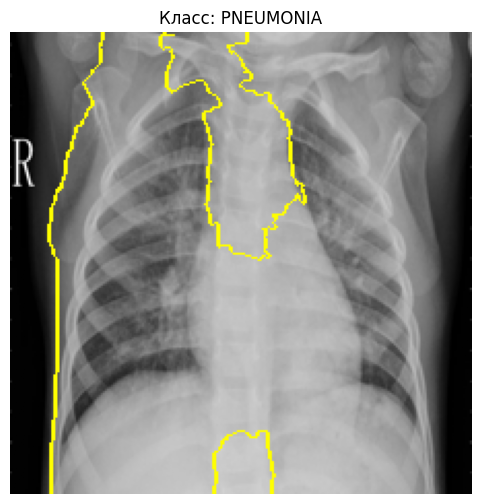

In [114]:
plt.figure(figsize=(6, 6))
plt.imshow(mark_boundaries(temp / 255.0, mask))
plt.title(f"Класс: {class_names[explanation.top_labels[0]]}")
plt.axis('off')
plt.show()


## Вывод
В рамках данной работы была реализована и дообучена сверточная нейросеть ResNet18 для автоматической классификации рентгеновских снимков грудной клетки на два класса: NORMAL (норма) и PNEUMONIA (пневмония). Использовался медицинский датасет Chest X-Ray Images (Pneumonia), содержащий реальные клинические снимки. Для интерпретации предсказаний нейросети использовался метод LIME (Local Interpretable Model-agnostic Explanations). Он позволил визуально определить, какие области изображения оказывали наибольшее влияние на решение модели. В случае с пневмонией это часто были затемнения в нижних долях лёгких, что совпадает с медицинскими признаками заболевания.